In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [3]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.03271651268005371 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


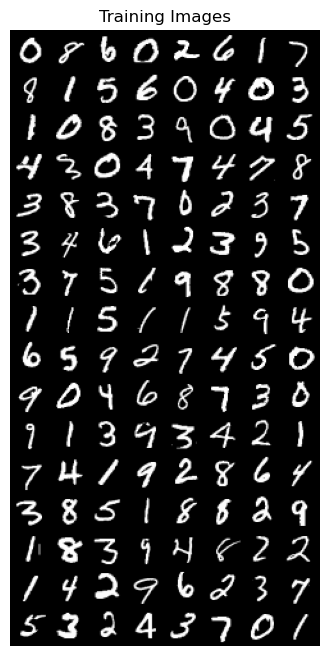

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [5]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [6]:
training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=1,
                                 num_dis_updates=5,
                                 num_gen_updates=1,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [7]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [8]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 321.545402	Loss_C : -2.966142	Loss_G : -4.657522	
Total_Time : 321.545402
Loss_C : -2.966142
Loss_G : -4.657522
Loss_C_Mean : -3.578358
Loss_G_Mean : -1.228824

----------------------------------------------



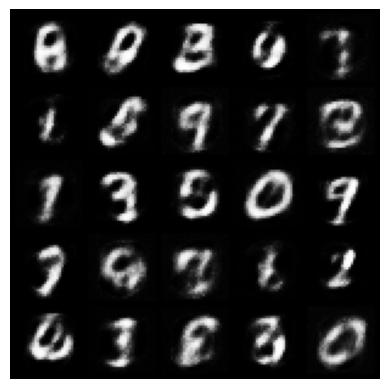

In [9]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25)

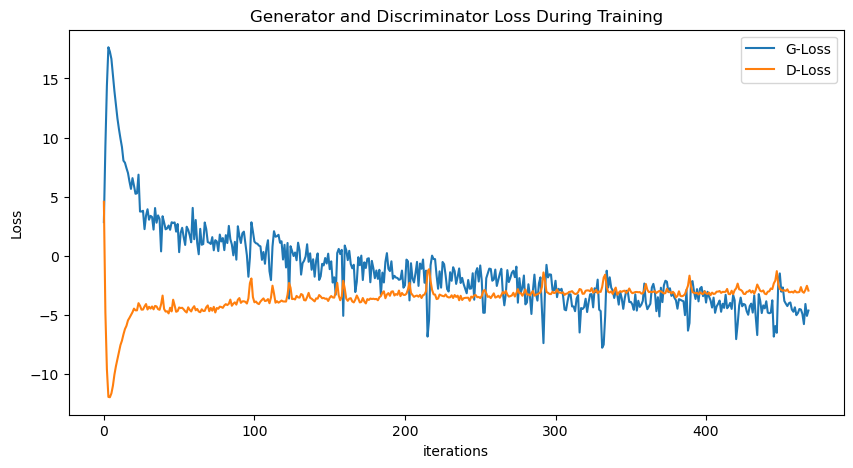

In [10]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

## BHS Gan

In [11]:
training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=2, num_gen_updates=1, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [12]:
# training loop
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 104.592660	Loss_C : -54.584085	Loss_G : -0.722367				
Total_Time : 104.592660
Loss_C : -54.584085
Loss_G : -0.722367
Loss_C_Mean : -252.951177
Loss_G_Mean : -42.827356

----------------------------------------------



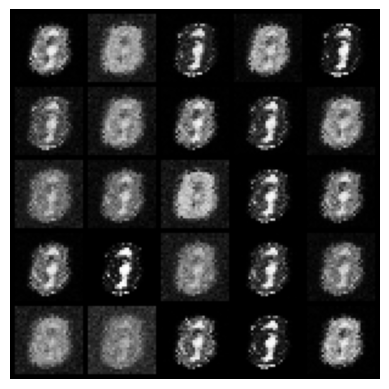

In [13]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=25)

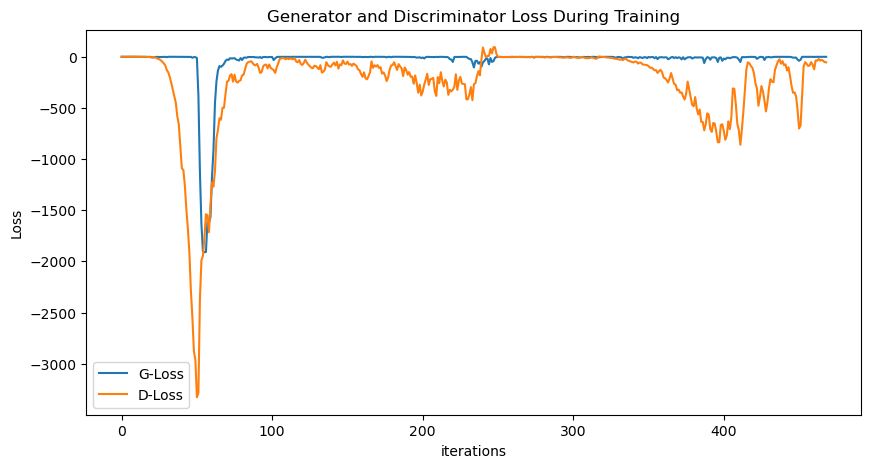

In [14]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## IPM BHS GAN

In [17]:
training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=5, num_gen_updates=1, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [18]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 156.963749	Loss_C : -26.251930	Loss_G : -47.110443		
Total_Time : 156.963749
Loss_C : -26.251930
Loss_G : -47.110443
Loss_C_Mean : -128.501740
Loss_G_Mean : 143.992394

----------------------------------------------



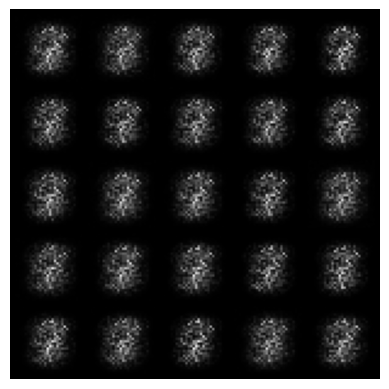

In [19]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

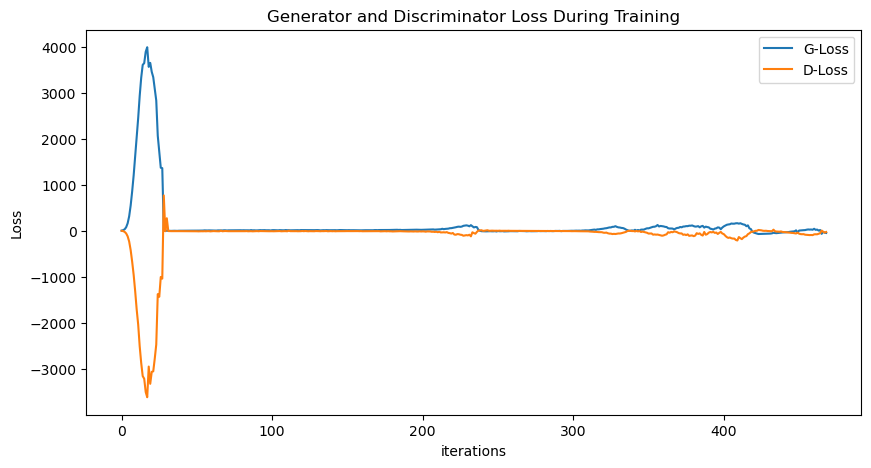

In [20]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)